In [ ]:
# default_exp core
# default_cls_lvl 3

In [ ]:
#hide
%load_ext line_profiler
%matplotlib notebook

# Corefunctions
> Corefunctionality for data preparation of sequential data for pytorch, fastai models

# Application Structure
The data will be extracted and prepared via transforms. Those are grouped in:
- Type Transforms: Those extraxt the needed components from the source items, like input sequences or target scalar values. The work on single tensors.
- Item Transforms: Those Transforms may work on tuple level and therefore may process relationships between input and output.
- Batch Transform: Those transforms work on batch level. They receive batched tensors and may apply lazy transforms like normalization very effeciently.

An application example may look like the following:
- sourceitems: 
    - path extraction with hdf5 file endings
    - create pandas dataframe with information for type transforms, like slices
    - filter items in pandas dataframe
- type transforms: 
    - extract hdf5 input and output sequence
    - create windows
- item transforms: 
    - filter sequence by value
    - shift output sequence by 1 element
- batch transforms: 
    - noise injection
    - normalization
    

In [ ]:
#export
from fastai2.data.all import *
import h5py

## 1. Extract Source Items
The file paths may be extracted with `get_files` of fastai2. `get_hdf_files` removes the need of writing the hdf5 file extension.

Then a pandas dataframe may be created in case further information for the source items need to be stored like slices for the windowing function.

### 1.1 Extract File Paths

In [ ]:
f_path = 'test_data/'
hdf_files = get_files(f_path,extensions='.hdf5',recurse=True)
len(hdf_files),hdf_files[0]

(3, Path('test_data/train/Sim_RealisticCycle2.hdf5'))

In [ ]:
#export
hdf_extensions = ['.hdf5']
def get_hdf_files(path,recurse=True, folders=None):
    "Get hdf5 files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=hdf_extensions, recurse=recurse, folders=folders)

In [ ]:
hdf_files = get_hdf_files(f_path)
len(hdf_files),hdf_files[0]

(3, Path('test_data/train/Sim_RealisticCycle2.hdf5'))

### 1.2 Create Source Dictionaries
In order to extract mulitple realizations of one file with different modifications, we create a list of properties. Pandas Dataframes are to slow for iteration but very fast and convenient for creations. So after creation of the pandas Dataframe we convert it to a list of dictionaries.

In [ ]:
#export
def apply_df_tfms(f_list,pd_tfms = None):
    '''Create Pandas Dataframe out of a list of items, with a list of df transforms applied'''
    df = pd.DataFrame(data=f_list.items,columns=['path'])
    if pd_tfms is not None:
        for t in pd_tfms:
            df = t(df)
    return df

In [ ]:
df = apply_df_tfms(hdf_files)
df.head()

,path
0,test_data/train/Sim_RealisticCycle2.hdf5
1,test_data/train/Sim_RealisticCycle1.hdf5
2,test_data/valid/Sim_RealisticCycle3.hdf5


In [ ]:
#export
def CreateDict(pd_tfms = None):
    '''Create List of Dictionarys out of a list of items, with a list of df transforms applied'''
    def _inner(f_list):
        return apply_df_tfms(f_list,pd_tfms).to_dict(orient='records')
    return _inner

In [ ]:
l_dict =CreateDict()(hdf_files)
l_dict

[{'path': Path('test_data/train/Sim_RealisticCycle2.hdf5')},
 {'path': Path('test_data/train/Sim_RealisticCycle1.hdf5')},
 {'path': Path('test_data/valid/Sim_RealisticCycle3.hdf5')}]

In [ ]:
#export
def DfHDFCreateWindows(win_sz,stp_sz, clm, fixed_start = False, fixed_end = False):
    '''create windows of sequences, splits sequence into multiple items'''
    def _inner(df):
        if fixed_start and fixed_end: raise Exception

        lst_df = [] #new dataframe for every row
        for idx, row in df.iterrows():
            with h5py.File(row.path,'r') as f:
                #TODO make clm optional
#                 if clm == '': 
#                     clm = list(f.keys())[0]
                f_len = max(f[clm].shape)

                n_win = ((f_len-win_sz)//stp_sz)+1
                tmp_df = df.iloc[[idx]*n_win]; #duplicate the row of the df multiple times by reference
                lst_idx = np.arange(n_win)

                #every row is a reference so we need to suppress the warning messages while copying
                pd.options.mode.chained_assignment = None
                tmp_df['l_slc'] = None if fixed_start else lst_idx*stp_sz
                tmp_df['r_slc'] = None if fixed_end else lst_idx*stp_sz + win_sz
                pd.options.mode.chained_assignment = 'warn'

                lst_df.append(tmp_df)

        res_df = pd.concat(lst_df)
        return res_df
    
    return _inner

In [ ]:
%%time
create_win = DfHDFCreateWindows(win_sz=100,stp_sz=100,clm='current')
create_win(df).head()

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 15 ms


In [ ]:
%%time
tfm_src = CreateDict([DfHDFCreateWindows(win_sz=100+1,stp_sz=10,clm='current')])
src_dicts = tfm_src(hdf_files)
src_dicts[:5]

CPU times: user 1.56 s, sys: 41.1 ms, total: 1.6 s
Wall time: 1.6 s


## 2. Convert Paths to Sequence Objects
Der Pfad wird unter Angabe der Spaltennamen in Sequenzen und Skalare Werte umgewandelt, um so am Ende ein 3-Tupel zu erhalten aus:
- (Sequence, Scalar, Sequence) <-> (input,input,output)

### 2.1 Extract sequential data from hdf5-files
Two different functions, based on pandas df and on lists

#### 2.1.1 Shift time Series
Sometimes we need to shift columns of a sequence by a specific value. Then we cant simply slice the array but have to handle each column individually. First a performance test has to be made.

In [ ]:
#export
def calc_shift_offsets(clm_shift):
    clm_shift = array(clm_shift)
    l_offs = -min(clm_shift.min(),0)
    r_offs = -max(clm_shift.max(),0)
    l_shift = clm_shift+l_offs
    r_shift = clm_shift+r_offs
    dim_red = l_offs-r_offs
    return l_shift,r_shift,dim_red

In [ ]:
shft = [0,0,-1,1]
calc_shift_offsets(shft)

(array([1, 1, 0, 2]), array([-1, -1, -2,  0]), 2)

both shifting methods have their own performance character. vstack needs double the time on short sequences, while the creation of a seperate array with copy becomes worse starting at around 5000 elements

In [ ]:
# ta = array([[1,2,3]*2]*10000)

In [ ]:
# %%timeit
# y = np.vstack([ta[i:-ta.shape[1]+i,i] for i in range(ta.shape[1])]).T   

In [ ]:
# %%timeit
# x = np.zeros((ta.shape[0]-ta.shape[1],ta.shape[1]))
# for i in range(ta.shape[1]):
#     x[:,i] = ta[i:-ta.shape[1]+i,i]

#### 2.1.2 HDF2Sequence

In [ ]:
#export
from functools import lru_cache

def HDF2Sequence(clm_names,clm_shift=None,to_cls=Tensor,cached=True):
    if not clm_shift is None:
        assert len(clm_shift)==len(clm_names) and all(isinstance(n, int) for n in clm_shift)
        l_shift,r_shift,dim_red = calc_shift_offsets(clm_shift)
    
    def _extract_sequence(hdf_path,dataset = None, l_slc = None, r_slc= None):
        with h5py.File(hdf_path,'r') as f:
            ds = f if dataset is None else f[dataset]
            l_array = [ds[n][l_slc:r_slc] for n in clm_names]
            seq = np.vstack(l_array).T
            return seq
        
    _exseq = lru_cache(maxsize=None)(_extract_sequence) if cached else _extract_sequence
    
    def _extract_dict_sequence(item):
        if isinstance(item,dict):
            path = item['path']
            dataset = item['dataset'] if 'dataset' in item else None
            l_slc = item['l_slc'] if 'l_slc' in item else None
            r_slc = item['r_slc'] if 'r_slc' in item else None

            if cached:
                seq = _exseq(path,dataset)[l_slc:r_slc]
            else:
                seq = _exseq(path,dataset,l_slc,r_slc)
        else:
            seq = _exseq(str(item))

        #shift clms of result by given value 
        if not clm_shift is None:
            l_seq = seq.shape[0]
            seq = np.vstack([seq[l_shift[i]:l_seq+r_shift[i],i] for i in range(seq.shape[1])]).T 

        #it is important to slice first and then do the class conversion
        return to_cls(seq)

    return _extract_dict_sequence

In [ ]:
# %%timeit
hdf2seq = HDF2Sequence(['current','voltage'],cached=False)
hdf2seq(hdf_files[0])

tensor([[ 0.0000,  4.1874],
        [-0.0052,  4.1875],
        [-0.0090,  4.1875],
        ...,
        [ 1.0783,  3.7160],
        [ 1.0739,  3.7161],
        [ 1.0706,  3.7162]])

In [ ]:
hdf2seq = HDF2Sequence(['current','voltage'],clm_shift=[1,1])
hdf2seq(hdf_files[0])

tensor([[-0.0052,  4.1875],
        [-0.0090,  4.1875],
        [-0.0114,  4.1876],
        ...,
        [ 1.0783,  3.7160],
        [ 1.0739,  3.7161],
        [ 1.0706,  3.7162]])

In [ ]:
hdf2seq = HDF2Sequence(['current','voltage'],cached=True)

In [ ]:
# %%timeit
hdf2seq(hdf_files[0])

tensor([[ 0.0000,  4.1874],
        [-0.0052,  4.1875],
        [-0.0090,  4.1875],
        ...,
        [ 1.0783,  3.7160],
        [ 1.0739,  3.7161],
        [ 1.0706,  3.7162]])

Die Funktion lässt sich mittels Pipeline auf eine Liste von Quellobjekten (hier Pfade) anwenden 

In [ ]:
hdf2seq = HDF2Sequence(['current'])
hdf2seq(hdf_files[0]).shape

torch.Size([265598, 1])

In [ ]:
pipe = Pipeline(HDF2Sequence(['current','voltage']))

In [ ]:
res_pipe = pipe(hdf_files)
len(res_pipe), res_pipe[0][0]

(3, tensor([0.0000, 4.1874]))

In [ ]:
#export
def hdf2scalars(hdf_path,c_names):
    with h5py.File(hdf_path,'r') as f:
#         import pdb; pdb.set_trace()
#         l_array = [f[n][:][:,None] for n in c_names]
#         seq = np.concatenate(l_array,axis=1)
        return None

#### Performance Test
Caching stores the arrays for future use at every function call. Very usefull, especially for windows. Should allways be turned. Only explicitly turn it off when there is not enough memory for your data.

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage'],cached=False)],
        [HDF2Sequence(['voltage'],cached=False)]]
dsrc = DataSource(src_dicts[:1000],tfms=tfms)

In [ ]:
len(dsrc)

1000

In [ ]:
# %%time
# for x in dsrc:
#     x

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage'],cached=True,clm_shift=[1,2])],
        [HDF2Sequence(['voltage'],cached=True)]]
dsrc = DataSource(src_dicts[:1000],tfms=tfms)

In [ ]:
%%timeit
for x in dsrc:
    x

174 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Caching is way faster because every file gets loaded multiple times

### 2.1 Datatypes for Sequences and Scalars

In [ ]:
#export
class TensorSequences(TensorBase):
#     def __init__(self,x,c_names=None, **kwargs):
#         super().__init__()
#         self.c_names = c_names
    
    def show(self, ctx=None, **kwargs):
#         import pdb; pdb.set_trace()
        ax = ctx
        if ax is None: _,ax = plt.subplots()
        ax.plot(self)
#         if title is not None: ax.set_title(title)
        return ax

    @classmethod
    def from_hdf(cls,clm_names,cached=True):
        return HDF2Sequence(clm_names=clm_names,cached=cached,to_cls=cls)
    
class TensorSequencesInput(TensorSequences): pass
class TensorSequencesOutput(TensorSequences): pass

In [ ]:
f = TensorSequencesInput.from_hdf(['current'])
type(f(hdf_files[0]))

__main__.TensorSequencesInput

In [ ]:
TensorSequences(x=[1,2],c_names=[2])

tensor([1, 2])

In [ ]:
# TensorSequences(np.ones((30,2))).show()

In [ ]:
#export
@Transform
def toTensorSequencesInput(o): return TensorSequencesInput(o)
@Transform
def toTensorSequencesOutput(o): return TensorSequencesOutput(o)

In [ ]:
#export
class TensorScalars(TensorBase): pass
class TensorScalarsInput(TensorScalars): pass
class TensorScalarsOutput(TensorScalars): pass

## 3. Transformations


### 3.1 Sequence Slicing Transformation

In [ ]:
#export 
class SeqSlice(Transform):
    '''Take a slice from an array-like object. Useful for e.g. shifting input and output'''
    def __init__(self, l_slc=None,r_slc=None):
        self.l_slc,self.r_slc = l_slc,r_slc
        
    def encodes(self, o): return o[self.l_slc:self.r_slc]

In [ ]:
l_shift = SeqSlice(r_slc=-1)
arr = np.ones((5))
test_eq(l_shift(arr),arr[:-1])

### 3.2 Sequence Noise Injection Transformation

In [ ]:
#export
class SeqNoiseInjection(Transform):
    split_idx=0
    '''Adds normal distributed noise to the tensor sequence with seperate mean and std for every signal'''
    def __init__(self, std=1e-1,mean=0.):
        self.std,self.mean = tensor(std),tensor(mean)
        
    def setups(self, dl:DataLoader):
        #check the tensor type of your input
        #TODO: include scalar type case
        x,*_ = dl.one_batch()
        self.std = to_device(self.std,x.device)
        self.mean = to_device(self.mean,x.device)
        
    def encodes(self, o:TensorSequencesInput): 
        #expand creates a view on a tensor and is therefore very fast compared to copy
        return o+torch.normal(mean=self.mean.expand_as(o), 
                              std=self.std.expand_as(o))

In [ ]:
x = TensorSequencesInput(tensor([[1,1,1],[-1,-1,-1.0]]))
ns_mean = tensor([0.,10.1,3.1])
ns_std = tensor([1.,1.1,0.1])
x,x.shape

(tensor([[ 1.,  1.,  1.],
         [-1., -1., -1.]]), torch.Size([2, 3]))

In [ ]:
seq_noise = SeqNoiseInjection(std=ns_std,mean=ns_std)
seq_noise(x)

tensor([[ 1.,  1.,  1.],
        [-1., -1., -1.]])

In [ ]:
seq_noise = SeqNoiseInjection(std=ns_std*10)
seq_noise(x)

tensor([[ 1.,  1.,  1.],
        [-1., -1., -1.]])

### 3.3 Normalization
`Normalize` is programmed for `TensorImage` as an input tensor. It gets. At init the variable axes need to be chosen correspondingly to the shape of your tensor.

In [ ]:
#export
@Normalize
def encodes(self, x:TensorSequencesInput): 
    return (x-self.mean) / self.std

@Normalize
def decodes(self, x:TensorSequencesInput):
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))

In [ ]:
norm = Normalize.from_stats(mean=ns_mean,std=ns_std,dim=1,ndim=2,cuda=False)
x,norm(x)

(tensor([[ 1.,  1.,  1.],
         [-1., -1., -1.]]), tensor([[  1.0000,  -8.2727, -21.0000],
         [ -1.0000, -10.0909, -41.0000]]))

## 4. Split in Training, Validation
Splitting kann anhand von vorher bekannten Indizes, dem Dateipfad oder anderen allgemeinen Funktion durchgeführt werden.

Splitting innerhalb einer Sequenzen sollte in der Praxis nur dann geschehen wenn eine einzige Sequenz vorhanden ist. Diese kann dann vorher manuell geteilt werden.


### 4.1 Splitting mit vorgegebenem Index

In [ ]:
splitter = IndexSplitter([1,2])
test_eq(splitter(hdf_files),[[0],[1,2]])

### 4.2 Splitting mit allgemeiner Funktion
Items, bei denen die definierte Funktion `True` zurück gibt, werden den Validierungsdatensatz zugeordnet, der Rest dem Training. In diesem Fall wird nach dem Übergeordneten Ordnernamen gesucht.

In [ ]:
splitter = FuncSplitter(lambda o: Path(o).parent.name == 'valid')
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.3 Splitting anhand des Parent-Folders
Splitter, der Explizit Training und Validierungsordner den Datensätzen zuordnet

In [ ]:
#export
def _parent_idxs(items, name): return mask2idxs(Path(o).parent.name == name for o in items)

def ParentSplitter(train_name='train', valid_name='valid'):
    "Split `items` from the parent folder names (`train_name` and `valid_name`)."
    def _inner(o, **kwargs):
        return _parent_idxs(o, train_name),_parent_idxs(o, valid_name)
    return _inner

In [ ]:
splitter = ParentSplitter()
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.4 Percentage Splitter

In [ ]:
#export
def PercentageSplitter(pct=0.8):
    "Split `items` in order in relative quantity."
    def _inner(o, **kwargs):
        split_idx=int(len(o)*pct)
        return L(range(split_idx)),L(range(split_idx,len(o)))
    return _inner

In [ ]:
splitter = PercentageSplitter(0.7)
test_eq(splitter(hdf_files),[[0,1],[2]])

### 4.5 Apply To Dictionary
In Case of the Datablock API your items are a list of dictionaries. If you want to apply a Splitter to the path stored within you need a wrapper function.

In [ ]:
#export
def ApplyToDict(fn,key='path'):
    return lambda x:fn([i[key] for i in x])

## 5. Databunch Creation
A Datasource combines all implemented components on item level.

In [ ]:
#export
def pad_sequence(batch):
    '''collate_fn for padding of sequences of different lengths, use in before_batch of databunch, still quite slow'''
    #takes list of tuples as input, returns list of tuples
    sorted_batch = sorted(batch, key=lambda x: x[0].shape[0], reverse=True)

    pad_func = partial(torch.nn.utils.rnn.pad_sequence,batch_first=True)
    padded_tensors = [pad_func([x[tup] for x in sorted_batch]) for tup in range(len(batch[0]))]
    padded_list = [retain_types(tuple([tup[entry] for tup in padded_tensors]),batch[0]) for entry in range(len(batch))]
    #retain types is important for decoding later back to source items
#     import pdb; pdb.set_trace()
    
    return padded_list

### 5.1 Low-Level with Transforms

In [ ]:
tfms=[  [HDF2Sequence(['current','voltage']),SeqSlice(l_slc=1),toTensorSequencesInput],
        [HDF2Sequence(['voltage']),SeqSlice(r_slc=-1),toTensorSequencesOutput]]
splits = splitter([x['path'] for x in src_dicts])
dsrc = DataSource(src_dicts,tfms=tfms,splits=splits)

In [ ]:
# %%timeit
# dsrc[0]

In [ ]:
db = dsrc.databunch(bs=128,after_batch=[Cuda(),SeqNoiseInjection(std=[1.1,0.01]),Normalize(axes=[0,2])],before_batch=pad_sequence)
db.one_batch()[0].shape

torch.Size([128, 100, 2])

### 5.2 Mid-Level with Datablock API

In [ ]:
#export
class SequenceBlock(TransformBlock):
    def __init__(self, seq_extract,padding=False):
        return super().__init__(type_tfms=[seq_extract],
                                batch_tfms=[Normalize(axes=[0,1])],
                                dbunch_kwargs={} if not padding else {'before_batch': pad_sequence})

    @classmethod
    @delegates(HDF2Sequence, keep=True)
    def from_hdf(cls, clm_names, seq_cls=TensorSequencesInput,padding=False, **kwargs):
        return cls(HDF2Sequence(clm_names,to_cls=seq_cls,**kwargs), padding)


In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['current','voltage'],TensorSequencesInput,padding=True),
                        SequenceBlock.from_hdf(['voltage'],TensorSequencesOutput)),
                get_items=tfm_src,
                splitter=ApplyToDict(ParentSplitter()))

In [ ]:
db = seq.databunch(hdf_files)

### 5.3 High-Level with SequenceDatabunch

## 6. Show Batches and Results

In [ ]:
#export
def plot_seqs_single_figure(n_samples,samples,outs=None):
    rows=max(1,((n_samples-1) // 3)+1)
    cols=min(3,n_samples)
    fig = plt.figure(figsize=(9,2*cols))
    outer_grid = fig.add_gridspec(rows, cols)
#     import pdb; pdb.set_trace()
    n_targ = samples[0][1].shape[1]
    for i in range(n_samples):
        in_signals = samples[i][0]
        targ_signals = samples[i][1]
        if outs is not None: out_signals = outs[i][0]
        inner_grid = outer_grid[i].subgridspec(n_targ+1, 1)
        for j in range(n_targ):
            ax = fig.add_subplot(inner_grid[j])
            ax.plot(targ_signals[:,j])
            if outs is not None: ax.plot(out_signals[:,j])
            ax.label_outer()

        ax = fig.add_subplot(inner_grid[n_targ])
        ax.plot(in_signals)
    plt.tight_layout()

In [ ]:
#export
def plot_seqs_multi_figures(n_samples,samples,outs=None):
    n_targ = samples[0][1].shape[1]
    for i in range(n_samples):
        fig = plt.figure(figsize=(9,3))
        axs = fig.subplots(nrows=n_targ+1,sharex=True)
        in_signals = samples[i][0]
        targ_signals = samples[i][1]
        if outs is not None:  out_signals = outs[i][0]
        for j in range(n_targ):
            ax = axs[j]
            ax.plot(targ_signals[:,j])
            if outs is not None:   ax.plot(out_signals[:,j])

        axs[-1].plot(in_signals)
        plt.tight_layout()

In [ ]:
#export
@typedispatch
def show_batch(x:TensorSequences, y:TensorSequences, samples, ctxs=None, max_n=6, **kwargs):
    n_samples = min(len(samples), max_n)
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,samples)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,samples)
    return ctxs

<IPython.core.display.Javascript object>


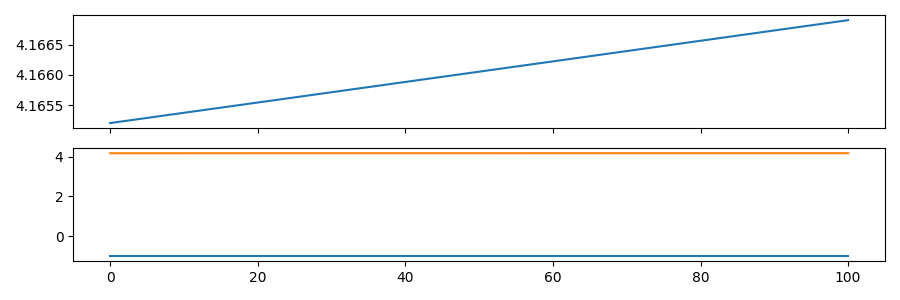

<IPython.core.display.Javascript object>


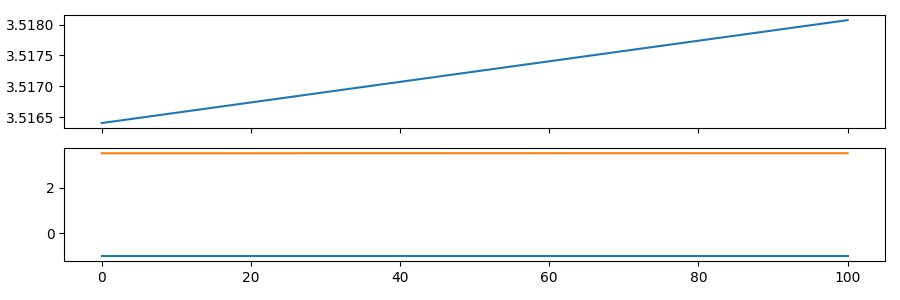

In [ ]:
db.show_batch(max_n=3)

In [ ]:
#export
@typedispatch
def show_results(x:TensorSequences, y:TensorSequences, samples, outs, ctxs=None, max_n=2, **kwargs):
    n_samples = min(len(samples), max_n)
    if n_samples > 3:
        #if there are more then 3 samples to plot then put them in a single figure
        plot_seqs_single_figure(n_samples,samples,outs)
    else:
        #if there are less then 3 samples to plot then put each in its own figure
        plot_seqs_multi_figures(n_samples,samples,outs)
    return ctxs

In [ ]:
#TODO

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_model.ipynb.
Converted 02_learner.ipynb.
Converted 10_performance_test.ipynb.
Converted 90_imu_example.ipynb.
Converted 91_cascaded_tanks.ipynb.
Converted 92_wiener_hammerstein.ipynb.
Converted 93_mdt_benchmark.ipynb.
Converted 93_noisyhammerstein.ipynb.
Converted 93_silverbox.ipynb.
Converted index.ipynb.
